In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["label", "message"])
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

PORTER_STEMMER = PorterStemmer()
ENG_STOPWORDS = stopwords.words("english")

def remove_punct(msgs):
    """ removes punctuation from a text_column in a df and converts it to lower case."""
    msgs = msgs.apply(lambda txt: txt.translate(str.maketrans("", "", string.punctuation)).lower())
    return msgs

def remove_stopwords(msgs):
    msgs = msgs.apply(lambda l: " ".join([word for word in l.split() if word not in ENG_STOPWORDS]))
    return msgs

def stem_words_porter(msgs):
    msgs = msgs.apply(lambda l: " ".join([PORTER_STEMMER.stem(word) for word in l.split()]))
    return msgs

def tokenize_words(msgs):
    msgs.apply(word_tokenize)
    return msgs

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

TXTCOL = "message"

preprocessing_pl = Pipeline([
    ("Remove Punctuation", FunctionTransformer(remove_punct)),
    ("Remove Stopwords", FunctionTransformer(remove_stopwords)),
    ("Porter Stemmer", FunctionTransformer(stem_words_porter)),
])

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

conversion_pl = Pipeline([
    ("Count vectorize", CountVectorizer()),
    ("TFIDF", TfidfTransformer()),
])



In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(df["message"], df.label, random_state=1234)


xtrain = conversion_pl.fit_transform(preprocessing_pl.fit_transform(xtrain))
xtest = conversion_pl.transform(preprocessing_pl.transform(xtest))

def single_str(msg):
    s = pd.Series(msg)
    return conversion_pl.transform(preprocessing_pl.transform(s))


In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

naive_bayes = MultinomialNB()
naive_bayes.fit(xtrain, ytrain)
preds = naive_bayes.predict(xtest)
print("=== BASELINE: NAIVE BAYES ===\n")
print(classification_report(ytest, preds))


=== BASELINE: NAIVE BAYES ===

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1208
        spam       0.99      0.68      0.80       185

    accuracy                           0.96      1393
   macro avg       0.97      0.84      0.89      1393
weighted avg       0.96      0.96      0.95      1393



In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(xtrain, ytrain)
preds = lr.predict(xtest)
print("=== LOGISTIC REGRESSION ===\n")
print(classification_report(ytest, preds))


=== LOGISTIC REGRESSION ===

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1208
        spam       0.99      0.69      0.82       185

    accuracy                           0.96      1393
   macro avg       0.97      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



In [18]:
import keras

nn = keras.Sequential([
    keras.layers.Dense(units=10, input_dim=6893, activation="sigmoid"),
    keras.layers.Dense(units=1, activation="sigmoid")
])

nn.compile("nadam", "binary_crossentropy")
history = nn.fit(xtrain, ytrain.map({"ham":0, "spam":1}), validation_data=(xtest, ytest.map({"ham":0, "spam":1})), epochs=50, use_multiprocessing=True,batch_size=128)


Train on 4179 samples, validate on 1393 samples
Epoch 1/50
4179/4179 [==============================] - 6s 1ms/step - loss: 0.6477 - val_loss: 0.5666
Epoch 2/50
4179/4179 [==============================] - 2s 365us/step - loss: 0.5111 - val_loss: 0.4607
Epoch 3/50
4179/4179 [==============================] - 2s 366us/step - loss: 0.4271 - val_loss: 0.3989
Epoch 4/50
4179/4179 [==============================] - 2s 391us/step - loss: 0.3764 - val_loss: 0.3603
Epoch 5/50
4179/4179 [==============================] - 1s 315us/step - loss: 0.3427 - val_loss: 0.3336
Epoch 6/50
4179/4179 [==============================] - 1s 287us/step - loss: 0.3179 - val_loss: 0.3131
Epoch 7/50
4179/4179 [==============================] - 1s 303us/step - loss: 0.2974 - val_loss: 0.2955
Epoch 8/50
4179/4179 [==============================] - 1s 323us/step - loss: 0.2792 - val_loss: 0.2795
Epoch 9/50
4179/4179 [==============================] - 2s 385us/step - loss: 0.2621 - val_loss: 0.2643
Epoch 10/50
4179/4

=== SHALLOW NEURAL NET ===

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1208
           1       0.98      0.88      0.92       185

    accuracy                           0.98      1393
   macro avg       0.98      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



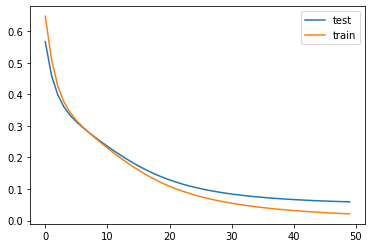

In [19]:
plt.plot(history.history["val_loss"], label="test")
plt.plot(history.history["loss"], label="train")
plt.legend()

print("=== SHALLOW NEURAL NET ===\n")
preds = nn.predict_classes(xtest)
print(classification_report(ytest.map({"ham":0, "spam":1}), preds))